In [ ]:
import sys
sys.path.insert(0, '/home/workspace/TissDiss')

from py_util import *

hdir = '/home/workspace/'
wdir = hdir + "/TissDiss/EXP-01244"
pltdir = wdir + "/plots/"
srldir = wdir + "/objects/"

raw_adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')
adata = sc.read_h5ad(srldir + 'processed_adata.h5ad')
adata = adata[adata.obs['harmony'] == 'no harmony']

In [5]:
def process_adata(adata):

    samples = adata.obs['base_sample'].values.unique().tolist()
    
    ds_adata = {}
    
    for sample in samples:
        if sample == 'OR07965-02':
            mask = adata.obs['base_sample'] == sample
            ds_adata[sample] = adata[mask]
            continue
    
        mask = adata.obs['base_sample'] == sample
        downsampled = sc.pp.subsample(
            adata[mask].copy(),
            n_obs = sum(adata.obs['base_sample'] == 'BMC07965-007'),
            random_state = 0,
            copy = True
        )
    
        ds_adata[sample] = downsampled
    
    adata = ad.concat(ds_adata, label = "base_sample", join = 'outer', merge = 'same')
    
    # Filtering out mitochondrial and Ig genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ig"] = adata.var_names.str.contains("^IG")
    
    adata = adata[:, (adata.var['mt'] == False) & (adata.var['ig'] == False)]

    # Applying scanpy processing pipeline
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt", "ig"],
        inplace=True,
        log1p=True
    )

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        batch_key="sample"
    )
    sc.tl.pca(adata)

    hm_adata = adata.copy()

    X = hm_adata.obsm['X_pca'].astype(np.float64)

    harmony_out = hm.run_harmony(X, hm_adata.obs, 'sample_type')

    hm_adata.obsm['X_pca'] = harmony_out.Z_corr.T

    adatas = {
        'adata': adata,
        'hm_adata': hm_adata
    }

    adatas['adata'].obs['harmony'] = 'no harmony'
    adatas['hm_adata'].obs['harmony'] = 'harmony'

    full_adata = ad.concat(adatas, join = 'outer', merge = 'same')

    sc.pp.neighbors(full_adata)
    sc.tl.draw_graph(full_adata)
    sc.tl.umap(full_adata)
    sc.tl.leiden(
        full_adata, 
        flavor="igraph", 
        n_iterations=2,
        resolution=1.1
    )
    sc.tl.paga(full_adata, groups='leiden')
    sc.tl.rank_genes_groups(
        full_adata, 
        groupby="leiden", 
        method="wilcoxon"
    )

    sc.tl.diffmap(full_adata)

    return full_adata[full_adata.obs['harmony'] == 'no harmony']

In [8]:
adata = process_adata(raw_adata)

bm_adata = adata[adata.obs['sample_type'] == 'bm']

range = np.round(np.arange(0.5, 3.0, 0.1), 1)

for res in range:
    sc.tl.leiden(
        bm_adata, 
        flavor="igraph",
        key_added=f"leiden_{str(res).replace('.', '_')}",
        n_iterations=2,
        resolution=res
    )

/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/workspace/TissDis

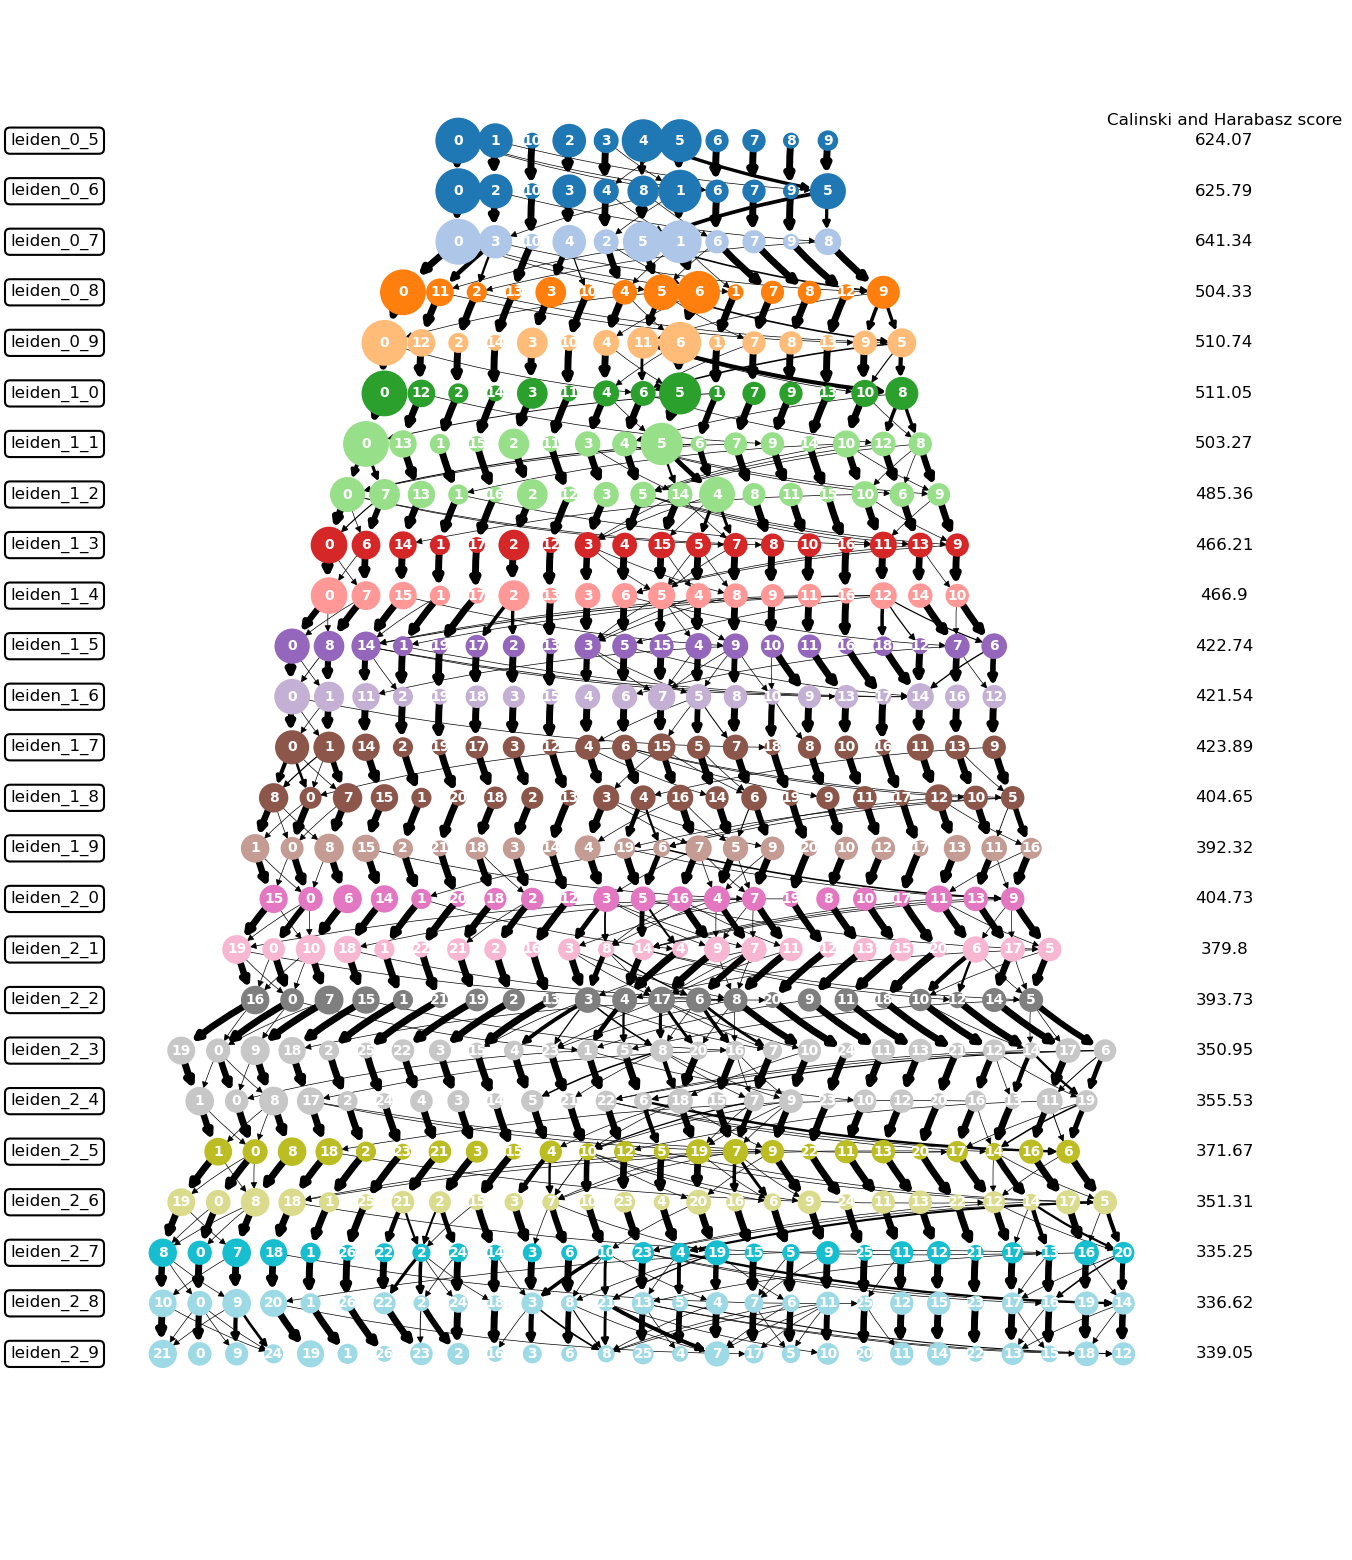

In [9]:
fig = clustree(
    bm_adata,
    [f"leiden_{str(res).replace('.', '_')}" for res in range],
    score_clustering="calinski_harabasz",
    score_basis="pca"
)

fig.set_size_inches(15, 20)
fig.set_dpi(100)

# Seperating cluster 13 into two different clusters

In [133]:
resolutions = np.round(np.arange(0, 0.05, 0.01), 2)

for res in resolutions:
    sc.tl.leiden(
        adata, 
        flavor="igraph",
        restrict_to=('leiden', ['13']),
        key_added=f"leiden_13_{str(res).replace('.', '_')}",
        n_iterations=2,
        resolution=res
    )

/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


In [ ]:
sc.tl.leiden(
    adata, 
    flavor="igraph",
    restrict_to=('leiden', ['13']),
    key_added="subclustered_leiden",
    n_iterations=2,
    resolution=0.04
)

labels = {key: key for key in adata.obs['subclustered_leiden'].unique()}
labels['13,2'] = '13,0'
labels['13,3'] = '13,0'

adata.obs['subclustered_leiden'] = [labels[x] if x in labels else x for x in adata.obs['subclustered_leiden']]

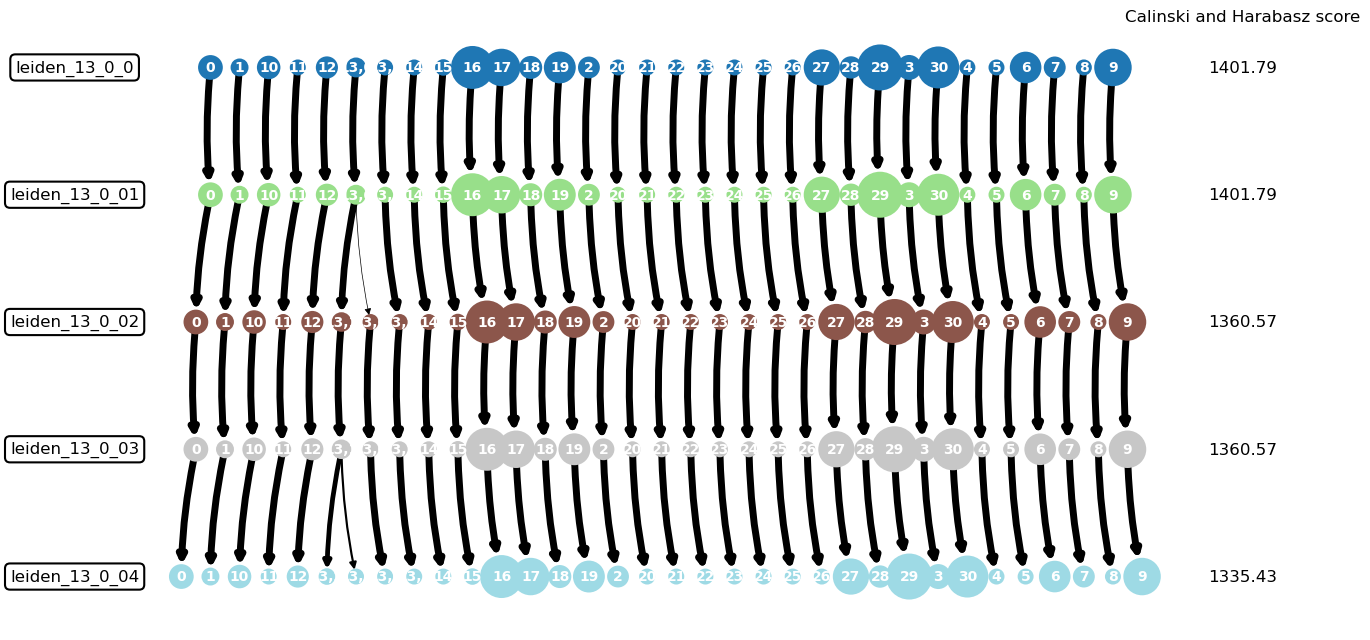

In [92]:
fig = clustree(
    adata,
    [f"leiden_13_{str(res).replace('.', '_')}" for res in resolutions],
    score_clustering="calinski_harabasz",
    score_basis="pca"
)

fig.set_size_inches(15, 8)
fig.set_dpi(100)

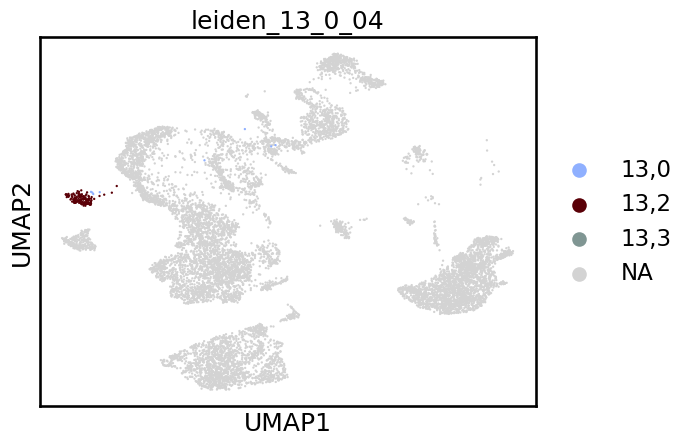

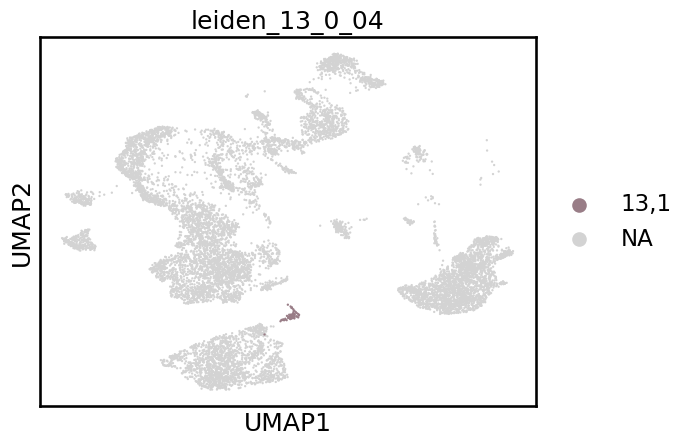

In [134]:
leiden13 = ['leiden_13_0_0', 'leiden_13_0_01', 'leiden_13_0_02', 'leiden_13_0_03', 'leiden_13_0_04']

clusters = list(adata.obs['leiden_13_0_04'].unique())
clusters = [cluster for cluster in clusters if "13" in cluster]

# for leiden in leiden13:
#     sc.pl.umap(adata, color=leiden, groups=clusters)

sc.pl.umap(adata, color='leiden_13_0_04', groups=['13,2', '13,0', '13,3'])
sc.pl.umap(adata, color='leiden_13_0_04', groups=['13,1'])

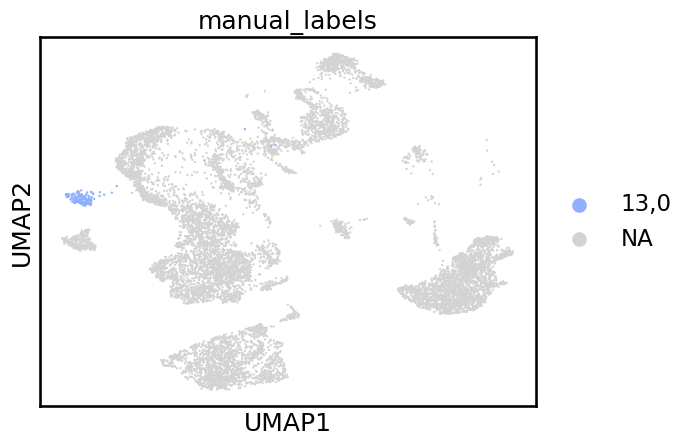

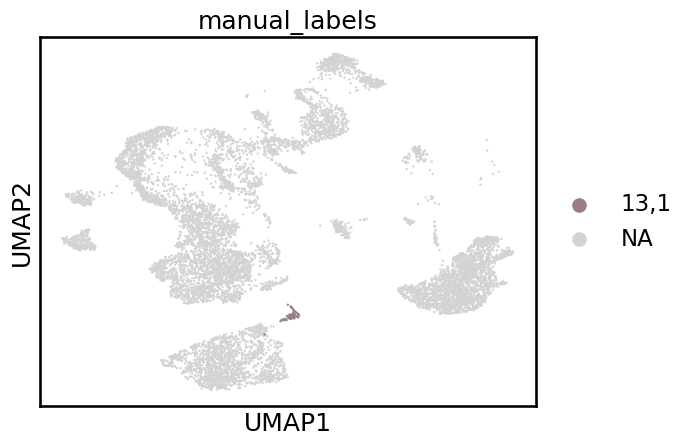

In [121]:
labelled_cells = {key: key for key in adata.obs['leiden_13_0_04'].unique()}
labelled_cells['13,2'] = '13,0'
labelled_cells['13,3'] = '13,0'

adata.obs['manual_labels'] = [labelled_cells[x] if x in labelled_cells else x for x in adata.obs['leiden_13_0_04']]

sc.pl.umap(adata, color='manual_labels', groups=['13,2', '13,0', '13,3'])
sc.pl.umap(adata, color='manual_labels', groups=['13,1'])

# Preprocessing with subclustering (c13)

In [1]:
def process_adata(adata):

    # Downsampling to bone marrow cell count, excluding the week 3 sample
    samples = adata.obs['base_sample'].values.unique().tolist()
    
    ds_adata = {}
    
    for sample in samples:
        if sample == 'OR07965-02':
            mask = adata.obs['base_sample'] == sample
            ds_adata[sample] = adata[mask]
            continue
    
        mask = adata.obs['base_sample'] == sample
        downsampled = sc.pp.subsample(
            adata[mask].copy(),
            n_obs = sum(adata.obs['base_sample'] == 'BMC07965-007'),
            random_state = 0,
            copy = True
        )
    
        ds_adata[sample] = downsampled
    
    adata = ad.concat(ds_adata, label = "base_sample", join = 'outer', merge = 'same')
    
    # Filtering out mitochondrial and Ig genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ig"] = adata.var_names.str.contains("^IG")
    
    adata = adata[:, (adata.var['mt'] == False) & (adata.var['ig'] == False)]

    # Applying scanpy processing pipeline
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt", "ig"],
        inplace=True,
        log1p=True
    )

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        batch_key="sample"
    )
    sc.tl.pca(adata)

    hm_adata = adata.copy()

    X = hm_adata.obsm['X_pca'].astype(np.float64)

    harmony_out = hm.run_harmony(X, hm_adata.obs, 'sample_type')

    hm_adata.obsm['X_pca'] = harmony_out.Z_corr.T

    adatas = {
        'adata': adata,
        'hm_adata': hm_adata
    }

    adatas['adata'].obs['harmony'] = 'no harmony'
    adatas['hm_adata'].obs['harmony'] = 'harmony'

    full_adata = ad.concat(adatas, join = 'outer', merge = 'same')

    sc.pp.neighbors(full_adata)
    sc.tl.draw_graph(full_adata)
    sc.tl.umap(full_adata)
    sc.tl.leiden(
        full_adata, 
        flavor="igraph", 
        n_iterations=2,
        resolution=1.1
    )

    sc.tl.leiden(
        full_adata, 
        flavor="igraph",
        restrict_to=('leiden', ['13']),
        key_added="leiden",
        n_iterations=2,
        resolution=0.04
    )
    
    # labels = {key: key for key in full_adata.obs['leiden'].unique()}
    # labels['13,2'] = '13,0'
    # labels['13,3'] = '13,0'
    
    # full_adata.obs['leiden'] = [labels[x] if x in labels else x for x in full_adata.obs['leiden']]
    
    # sc.tl.paga(full_adata, groups='leiden')
    # sc.tl.rank_genes_groups(
    #     full_adata, 
    #     groupby="leiden", 
    #     method="wilcoxon"
    # )

    sc.tl.diffmap(full_adata)

    return full_adata[full_adata.obs['harmony'] == 'no harmony']

adata = process_adata(raw_adata)

adata.obs['leiden'].unique()

# adata.write(srldir + 'subclustered_adata.h5ad', compression='gzip')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
  File "/tmp/ipykernel_212/1115689351.py", line 105, in <module>
    adata = process_adata(raw_adata)
NameError: name 'raw_adata' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
  File "/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceba

# misc